In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_2D
from project_utils.surroagte_gp     import Surrogate_GP

Num_Points = 1


X shape (10000, 2)
y shape (10000,)


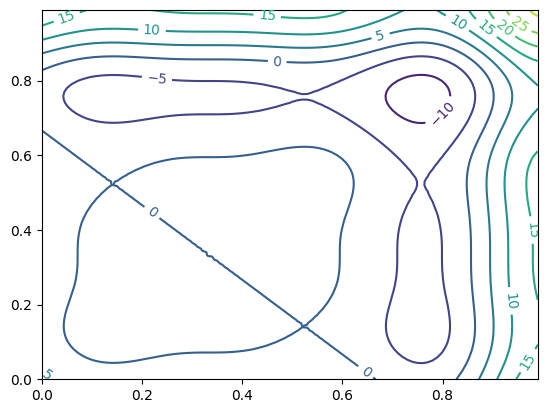

In [2]:
# Load Forrester model

Forrester_2Data = BB_Model('forrester_2d')

#Forrester_2Data.df().head()

In [3]:
Forrester_2Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8835097870343643


MLPRegressor(random_state=RandomState(MT19937) at 0x250ECAF9840)

In [4]:
Forrester_2Data.Random_Forest()

0.9993614079465604


RandomForestRegressor(random_state=RandomState(MT19937) at 0x250ECAF9840)

In [5]:
Forrester_2Data.GP()

0.9955225500106188


GaussianProcessRegressor()

In [6]:
print(Forrester_2Data.get_features())

['X1', 'X2']


In [7]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Forrester_2Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Forrester_2Data.get_GP(),
                   train_data           = X_train,
                   feature_names        = Forrester_2Data.get_features(),
                   categorical_features = Forrester_2Data.get_catagorical(),
                   mode                 = Forrester_2Data.get_mode(),
                   sampling_optimize    = "LHC")

#sur_GP = Surrogate_GP()


In [8]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [0.495545  0.4937575]
Std 0:  [0.2884575  0.28767135]


In [9]:
# Generate explantion data for Random Forest

Forrester_Stats = Feature_Statistics(feature_names = Forrester_2Data.get_features(), mode = Forrester_2Data.get_mode())

if Num_Points == 0: Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
#    data_row  = np.array([X_test[test_instance]])
    data_row  = np.array([0.3, 0.7])
    print('data row ',data_row)
    
    #scores, acq_data = URM_Exp.explain(X_init            = data_row.reshape(1, -1),
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Two',
                    kernel_type = "Matern",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    normalize   = False)

    scores = URM_Exp.permutation_importance()
    
    f_predict = Forrester_2Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(-1, 1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict)
    print(scores)
    
    Forrester_Stats.Add_Sample(sample_scores = scores,
                               outcome       = y_test[test_instance],
                               X_row         = data_row,
                               f_prediction  = f_predict,
                               e_prediction  = e_predict.ravel(),
                               feopt         = acq_data.get_fe_x0(),
                               model         = URM_Exp.get_exp_model())


INSTANCE:  0
data row  [0.3 0.7]
bounds [[0.0115425  0.41232865]
 [0.5884575  0.98767135]]
x1_range size 100
x2_range size 100
self.X1  10000
self.X2  10000


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


X1:	 6.57570
X2:	 35.86810
[-4.62113991] [-4.93539428e+00  1.00000004e-05]
[ 6.57570087 35.86810477]


In [10]:
import matplotlib.pyplot as plt


In [11]:
print(f_predict)
print(e_predict)


[-4.62113991]
[-4.93539428e+00  1.00000004e-05]


In [12]:
Forrester_Stats.Fidelity()

Average, Var, and Max Differences:
y - BB(x):           4.314622476266595  :  0.0  :  4.314622476266595
y - exp(x):          4.6288768482946665  :  0.0  :  4.6288768482946665
BB(x) - exp(x):      0.3142543720280715  :  0.0  :  0.3142543720280715
Average exp(x) var:  1.0000000413701846e-05


In [13]:
#Forrester_Stats.Jaccard_Values()

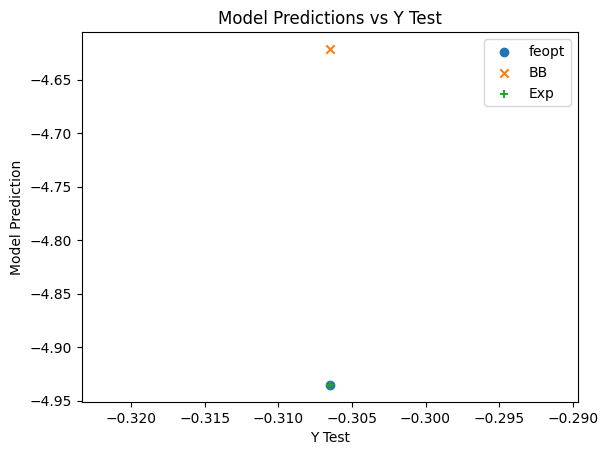

In [14]:
Forrester_Stats.Reg_Fidelity_Graph()

In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RBF

#X, y = URM_Exp.get_surrogate_data()
#kernel = Matern()

#GP = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer = 10, optimizer='fmin_l_bfgs_b', normalize_y = False, copy_X_train=True)
#GP.fit(X, y)
        
#print(y[0])
#fe = GP.predict(X[0].reshape(1,-1))
#print(fe)
#ey = URM_Exp.gpmodel_predict(X[0].reshape(1,-1))
#print(ey)


In [16]:
acq_data.Add_BB_model(Forrester_2Data.get_Random_Forest())



In [17]:
acq_data.Create_BB_plot()


IDX 0 - 99 : 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 , done!


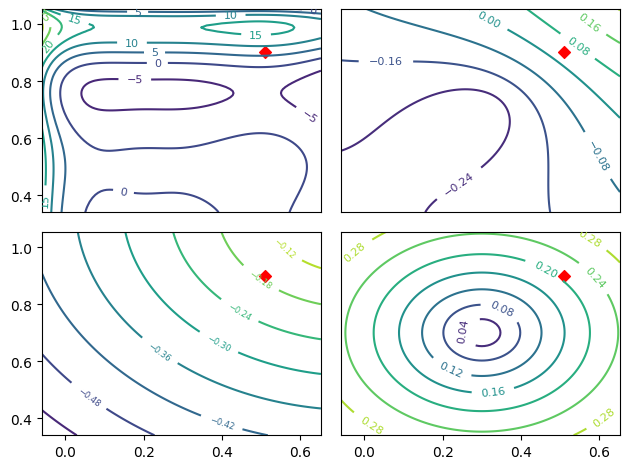

In [18]:
acq_data.plot_point(0)

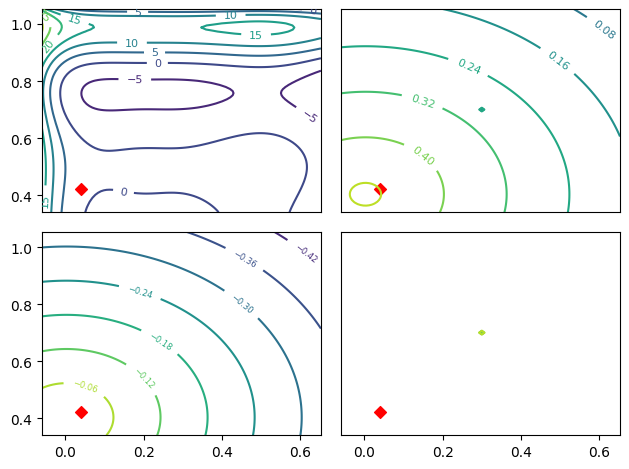

In [19]:
acq_data.plot_point(1)

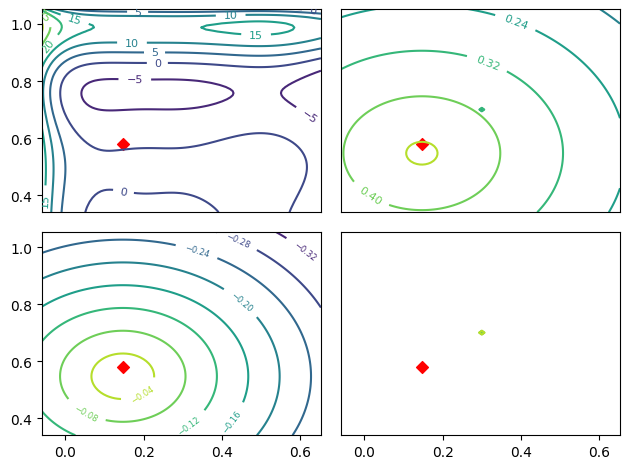

In [20]:
acq_data.plot_point(2)

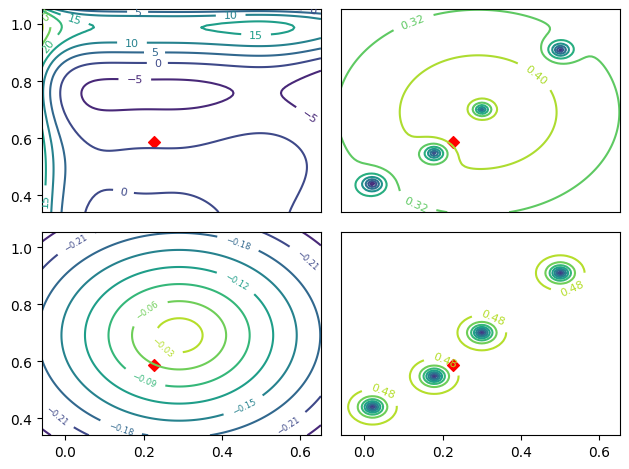

In [21]:
acq_data.plot_point(3)

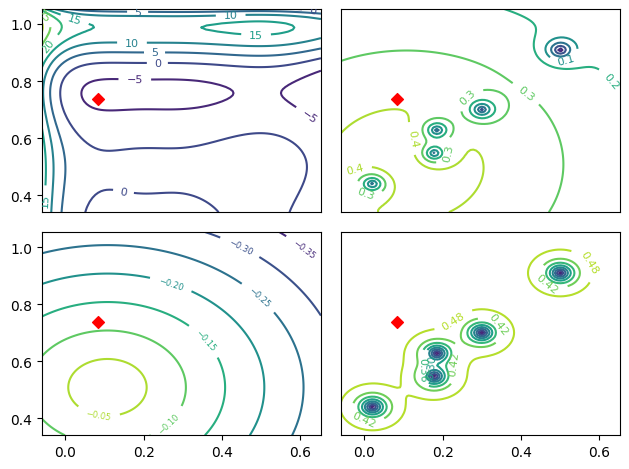

In [22]:
acq_data.plot_point(4)

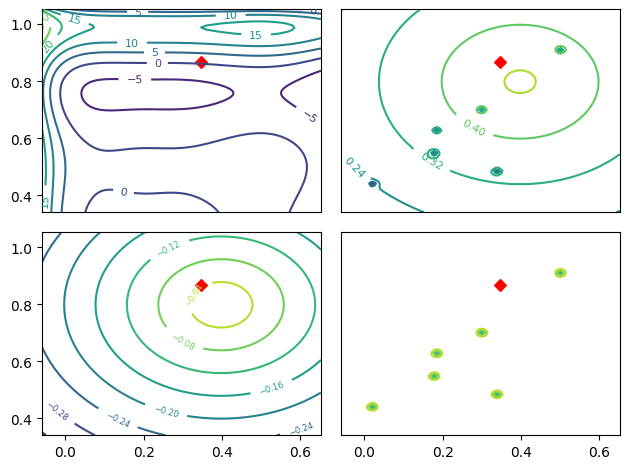

In [23]:
acq_data.plot_point(5)

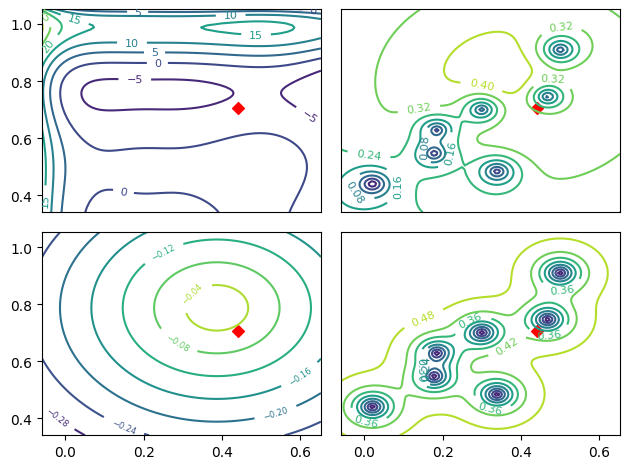

In [24]:
acq_data.plot_point(6)

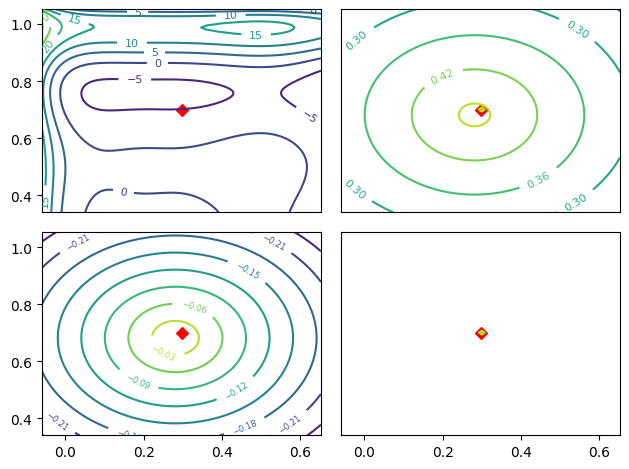

In [25]:
acq_data.plot_point(7)

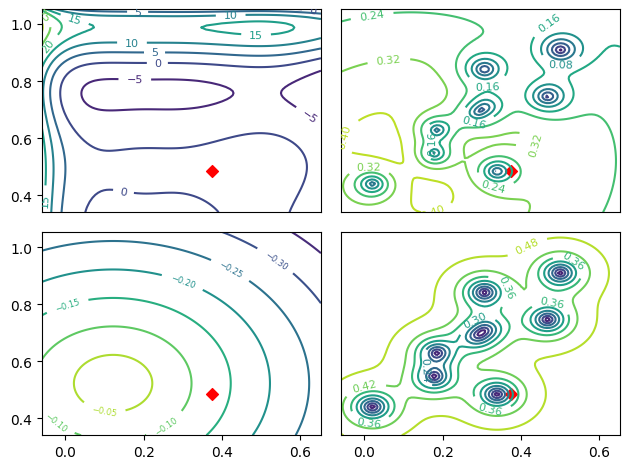

In [26]:
acq_data.plot_point(8)

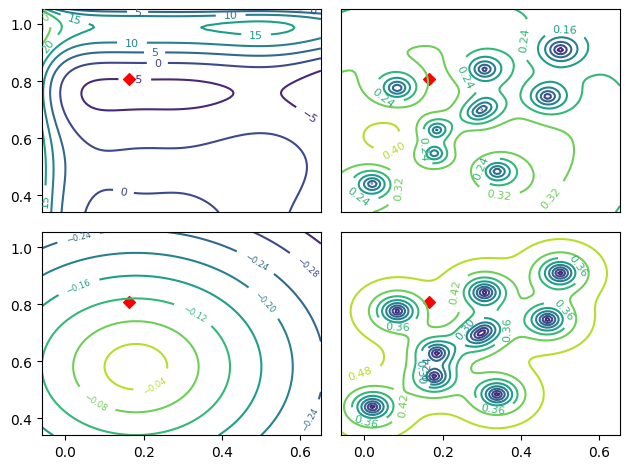

In [27]:
acq_data.plot_point(9)

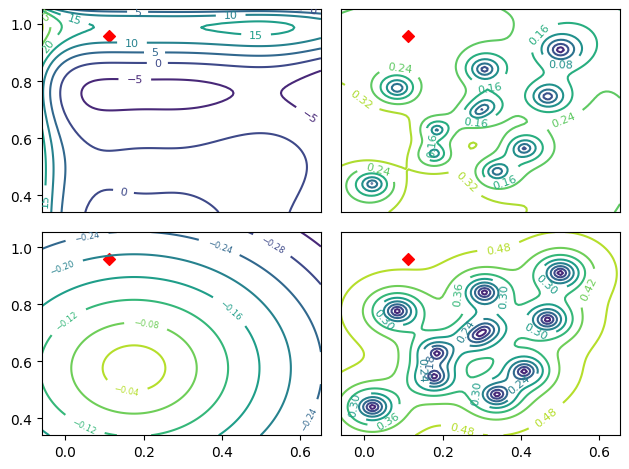

In [28]:
acq_data.plot_point(10)

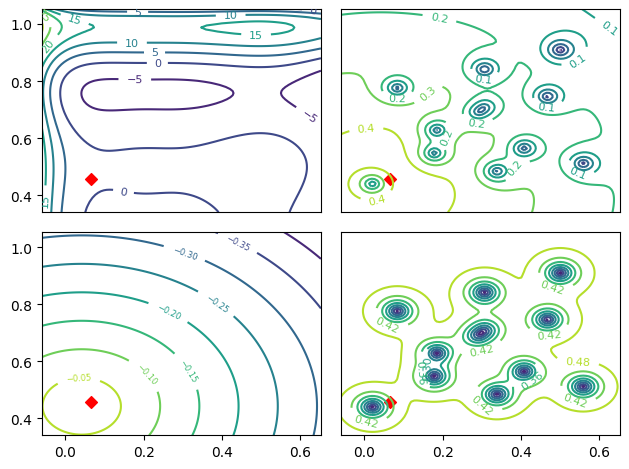

In [29]:
acq_data.plot_point(11)

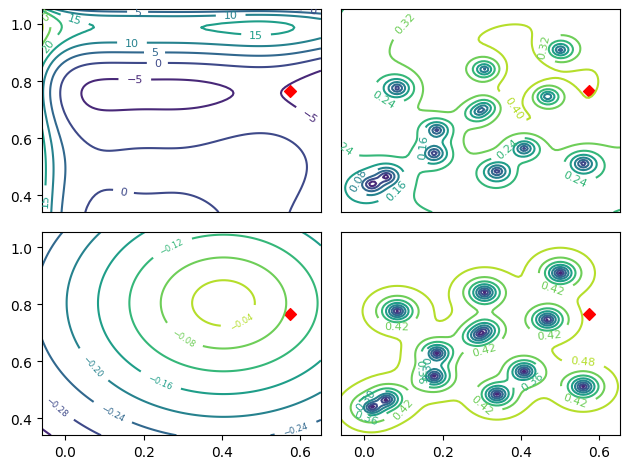

In [30]:
acq_data.plot_point(12)

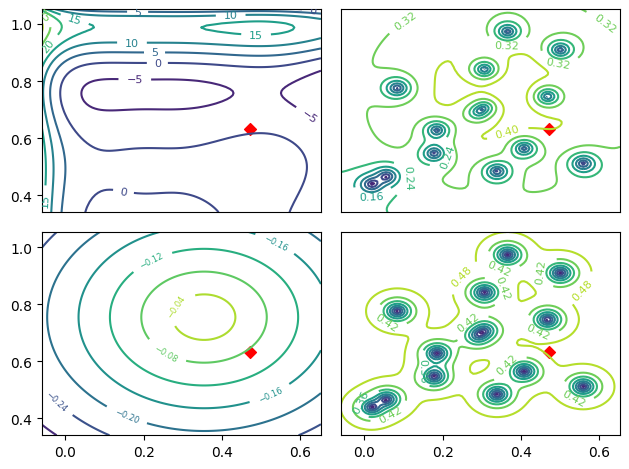

In [31]:
acq_data.plot_point(13)

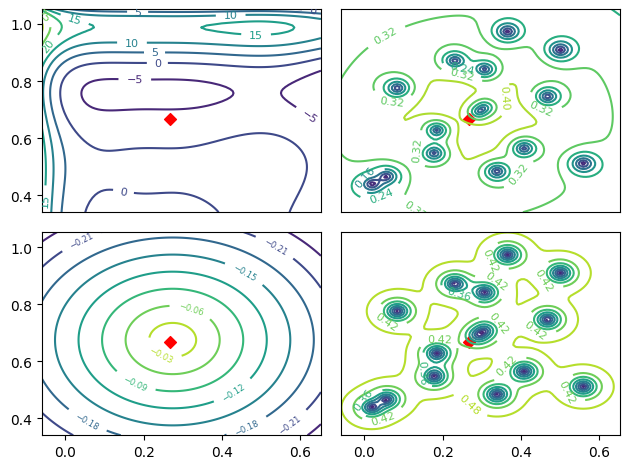

In [32]:
acq_data.plot_point(14)

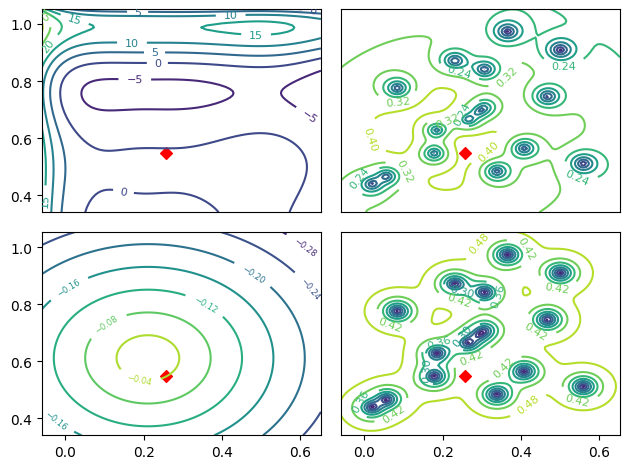

In [33]:
acq_data.plot_point(15)

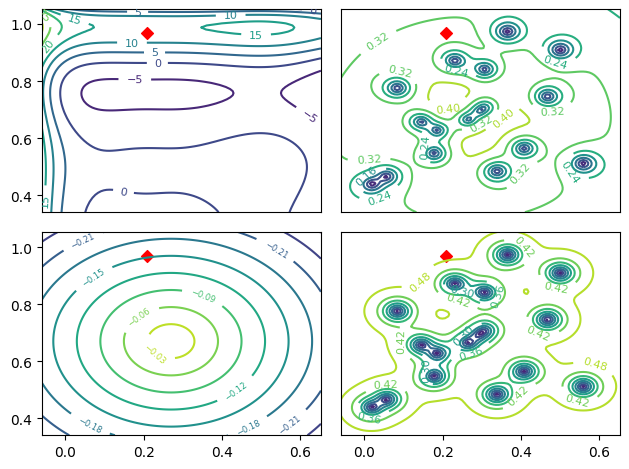

In [34]:
acq_data.plot_point(16)

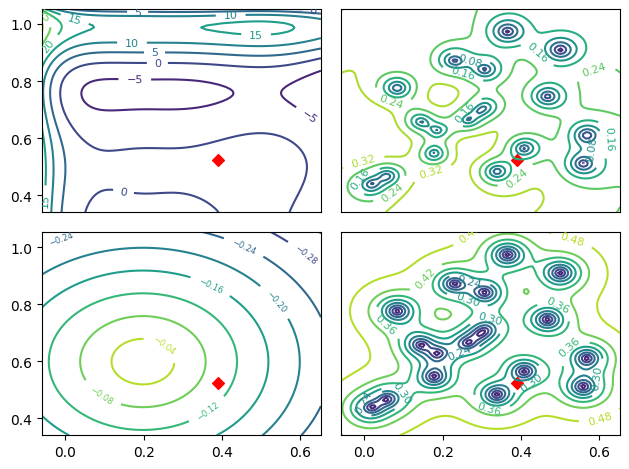

In [35]:
acq_data.plot_point(17)

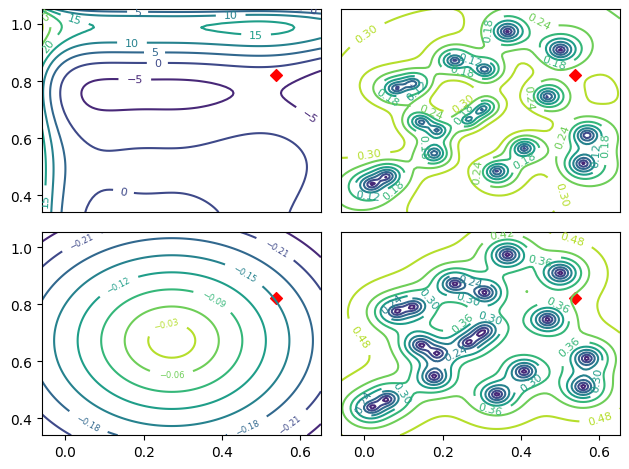

In [36]:
acq_data.plot_point(18)

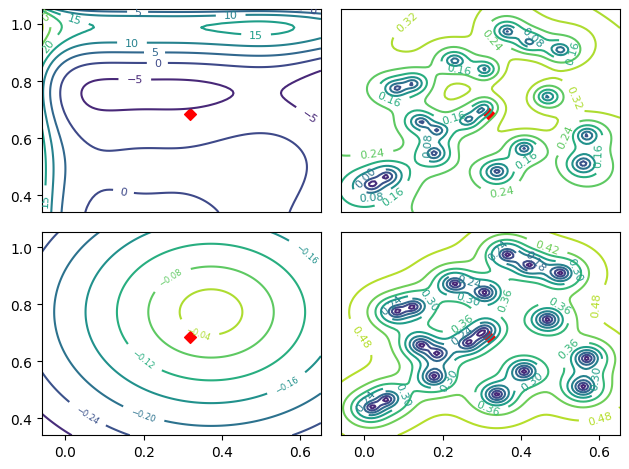

In [37]:
acq_data.plot_point(19)

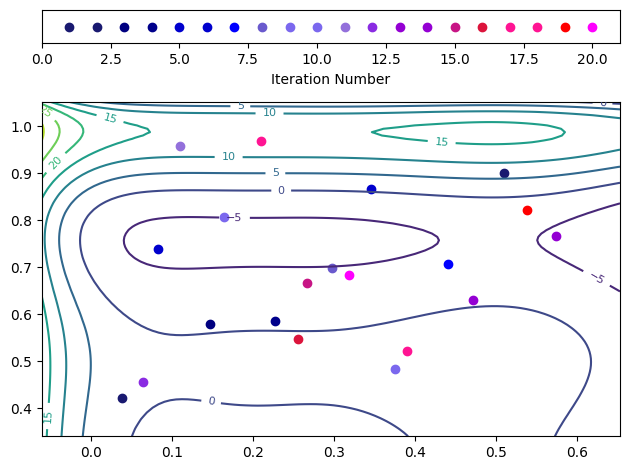

In [38]:
acq_data.plot_all()